This notebook is modified from a [LSTM Tutorial](https://github.com/nicodjimenez/lstm), which implements a minimal LSTM, both forward and backward, by NumPy.

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
# import os
# %cd /content/drive/MyDrive/graduation_project/FPTT-on-ANN/RNN/lstm-master/
# !pwd

In [19]:
import random

import numpy as np
import math

In [20]:
def sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def sigmoid_derivative(values): 
    return values*(1-values)

def tanh_derivative(values): 
    return 1. - values ** 2

In [21]:
# createst uniform random array w/ values in [a,b) and shape args
def rand_arr(a, b, *args): 
    np.random.seed(0)
    return np.random.rand(*args) * (b - a) + a

In [22]:
class LstmParam:
    def __init__(self, mem_cell_ct, x_dim):
        self.mem_cell_ct = mem_cell_ct
        self.x_dim = x_dim
        concat_len = x_dim + mem_cell_ct
        # weight matrices
        self.wg = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wi = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len) 
        self.wf = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wo = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.bg = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bi = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bf = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bo = rand_arr(-0.1, 0.1, mem_cell_ct) 

        self.rm_wg = self.wg
        self.rm_wi = self.wi
        self.rm_wf = self.wf
        self.rm_wo = self.wo
        self.rm_bg = self.bg
        self.rm_bi = self.bi
        self.rm_bf = self.bf
        self.rm_bo = self.bo

        self.lbd_wg = np.zeros((mem_cell_ct, concat_len)) 
        self.lbd_wi = np.zeros((mem_cell_ct, concat_len)) 
        self.lbd_wf = np.zeros((mem_cell_ct, concat_len)) 
        self.lbd_wo = np.zeros((mem_cell_ct, concat_len)) 
        self.lbd_bg = np.zeros(mem_cell_ct) 
        self.lbd_bi = np.zeros(mem_cell_ct) 
        self.lbd_bf = np.zeros(mem_cell_ct) 
        self.lbd_bo = np.zeros(mem_cell_ct) 

        # diffs (derivative of loss function w.r.t. all parameters)
        self.wg_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wi_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wf_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wo_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.bg_diff = np.zeros(mem_cell_ct) 
        self.bi_diff = np.zeros(mem_cell_ct) 
        self.bf_diff = np.zeros(mem_cell_ct) 
        self.bo_diff = np.zeros(mem_cell_ct) 

    def apply_diff(self, lr = 1):
        self.wg -= lr * self.wg_diff
        self.wi -= lr * self.wi_diff
        self.wf -= lr * self.wf_diff
        self.wo -= lr * self.wo_diff
        self.bg -= lr * self.bg_diff
        self.bi -= lr * self.bi_diff
        self.bf -= lr * self.bf_diff
        self.bo -= lr * self.bo_diff
        # reset diffs to zero
        self.wg_diff = np.zeros_like(self.wg)
        self.wi_diff = np.zeros_like(self.wi) 
        self.wf_diff = np.zeros_like(self.wf) 
        self.wo_diff = np.zeros_like(self.wo) 
        self.bg_diff = np.zeros_like(self.bg)
        self.bi_diff = np.zeros_like(self.bi) 
        self.bf_diff = np.zeros_like(self.bf) 
        self.bo_diff = np.zeros_like(self.bo) 



    def apply_diff_fptt(self, lr = 1, alpha = 0.001):
        self.wg -= lr * (self.wg_diff - self.lbd_wg + alpha*(self.wg - self.rm_wg))
        self.wi -= lr * (self.wi_diff - self.lbd_wi + alpha*(self.wi - self.rm_wi))
        self.wf -= lr * (self.wf_diff - self.lbd_wf + alpha*(self.wf - self.rm_wf))
        self.wo -= lr * (self.wo_diff - self.lbd_wo + alpha*(self.wo - self.rm_wo))
        self.bg -= lr * (self.bg_diff - self.lbd_bg + alpha*(self.bg - self.rm_bg))
        self.bi -= lr * (self.bi_diff - self.lbd_bi + alpha*(self.bi - self.rm_bi))
        self.bf -= lr * (self.bf_diff - self.lbd_bf + alpha*(self.bf - self.rm_bf))
        self.bo -= lr * (self.bo_diff - self.lbd_bo + alpha*(self.bo - self.rm_bo))

        self.lbd_wg -= alpha*(self.wg - self.rm_wg)
        self.lbd_wi -= alpha*(self.wi - self.rm_wi)
        self.lbd_wf -= alpha*(self.wf - self.rm_wf)
        self.lbd_wo -= alpha*(self.wo - self.rm_wo)
        self.lbd_bg -= alpha*(self.bg - self.rm_bg)
        self.lbd_bi -= alpha*(self.bi - self.rm_bi)
        self.lbd_bf -= alpha*(self.bf - self.rm_bf)
        self.lbd_bo -= alpha*(self.bo - self.rm_bo)

        self.rm_wg = 0.5*(self.rm_wg + self.wg) - (0.5/alpha)*self.lbd_wg 
        self.rm_wi = 0.5*(self.rm_wi + self.wi) - (0.5/alpha)*self.lbd_wi
        self.rm_wf = 0.5*(self.rm_wf + self.wf) - (0.5/alpha)*self.lbd_wf
        self.rm_wo = 0.5*(self.rm_wo + self.wo) - (0.5/alpha)*self.lbd_wo
        self.rm_bg = 0.5*(self.rm_bg + self.bg) - (0.5/alpha)*self.lbd_bg
        self.rm_bi = 0.5*(self.rm_bi + self.bi) - (0.5/alpha)*self.lbd_bi
        self.rm_bf = 0.5*(self.rm_bf + self.bf) - (0.5/alpha)*self.lbd_bf
        self.rm_bo = 0.5*(self.rm_bo + self.bo) - (0.5/alpha)*self.lbd_bo


        # reset diffs to zero
        self.wg_diff = np.zeros_like(self.wg)
        self.wi_diff = np.zeros_like(self.wi) 
        self.wf_diff = np.zeros_like(self.wf) 
        self.wo_diff = np.zeros_like(self.wo) 
        self.bg_diff = np.zeros_like(self.bg)
        self.bi_diff = np.zeros_like(self.bi) 
        self.bf_diff = np.zeros_like(self.bf) 
        self.bo_diff = np.zeros_like(self.bo)

In [23]:
class LstmState:
    def __init__(self, mem_cell_ct, x_dim):
        self.g = np.zeros(mem_cell_ct)
        self.i = np.zeros(mem_cell_ct)
        self.f = np.zeros(mem_cell_ct)
        self.o = np.zeros(mem_cell_ct)
        self.s = np.zeros(mem_cell_ct)
        self.h = np.zeros(mem_cell_ct)
        self.bottom_diff_h = np.zeros_like(self.h)
        self.bottom_diff_s = np.zeros_like(self.s)
   

In [24]:
class LstmNode:
    def __init__(self, lstm_param, lstm_state):
        # store reference to parameters and to activations
        self.state = lstm_state
        self.param = lstm_param
        # non-recurrent input concatenated with recurrent input
        self.xc = None

    def bottom_data_is(self, x, s_prev = None, h_prev = None):
        # if this is the first lstm node in the network
        if s_prev is None: s_prev = np.zeros_like(self.state.s)
        if h_prev is None: h_prev = np.zeros_like(self.state.h)
        # save data for use in backprop
        self.s_prev = s_prev
        self.h_prev = h_prev

        # concatenate x(t) and h(t-1)
        xc = np.hstack((x,  h_prev))
        self.state.g = np.tanh(np.dot(self.param.wg, xc) + self.param.bg)
        self.state.i = sigmoid(np.dot(self.param.wi, xc) + self.param.bi)
        self.state.f = sigmoid(np.dot(self.param.wf, xc) + self.param.bf)
        self.state.o = sigmoid(np.dot(self.param.wo, xc) + self.param.bo)
        self.state.s = self.state.g * self.state.i + s_prev * self.state.f
        self.state.h = self.state.s * self.state.o

        self.xc = xc


    ''' original BPTT method
        calculate the gradient of onward Loss w.r.t. h/s at a specific time step
        (and then corressponding weights/biases)
        1. this function is called when entire output sequence is obtained
        2. iterate this function from the last state to the first
        3. reduced repition of calculation
    '''
    def top_diff_is(self, top_diff_h, top_diff_s):
        # notice that top_diff_s is carried along the constant error carousel
        ds = self.state.o * top_diff_h + top_diff_s
        do = self.state.s * top_diff_h
        di = self.state.g * ds
        dg = self.state.i * ds
        df = self.s_prev * ds


        # diffs w.r.t. vector inside sigma / tanh function
        di_input = sigmoid_derivative(self.state.i) * di 
        df_input = sigmoid_derivative(self.state.f) * df 
        do_input = sigmoid_derivative(self.state.o) * do 
        dg_input = tanh_derivative(self.state.g) * dg

        # diffs w.r.t. inputs
        self.param.wi_diff += np.outer(di_input, self.xc)
        self.param.wf_diff += np.outer(df_input, self.xc)
        self.param.wo_diff += np.outer(do_input, self.xc)
        self.param.wg_diff += np.outer(dg_input, self.xc)
        self.param.bi_diff += di_input
        self.param.bf_diff += df_input       
        self.param.bo_diff += do_input
        self.param.bg_diff += dg_input       

        # compute bottom diff
        dxc = np.zeros_like(self.xc)
        dxc += np.dot(self.param.wi.T, di_input)
        dxc += np.dot(self.param.wf.T, df_input)
        dxc += np.dot(self.param.wo.T, do_input)
        dxc += np.dot(self.param.wg.T, dg_input)

        # save bottom diffs
        self.state.bottom_diff_s = ds * self.state.f
        self.state.bottom_diff_h = dxc[self.param.x_dim:]



In [25]:
class LstmNetwork():
    def __init__(self, lstm_param):
        self.lstm_param = lstm_param
        self.lstm_node_list = []
        # input sequence
        self.x_list = []



    ''' BPTT method: straightforward implementation
          no optimized as original method,
          but natural to consider,
          and importantly suitable for migration to [FPTT]  

        idea:
        at each time step, the pair of output and label result in a loss
        the loss depends on all previous [h], can be truncated
        each [h] depends on all previous [s], can be truncated


    '''
    def backward(self, y, loss_layer, trunc_h= None, trunc_s= None):

        assert len(y) == len(self.x_list)

        # gradient of l(t) w.r.t. h(t), h(t-1), ..., h(0)
        dh = np.zeros((len(self.x_list), self.lstm_param.mem_cell_ct))
        # gradient of l(t) w.r.t. h(t), h(t-1), ..., h(0) w.r.t. s(t), s(t-1), ..., s(0)
        ds = np.zeros((len(self.x_list), self.lstm_param.mem_cell_ct))

        loss = 0.

        for t in range (len(self.x_list)):

            loss += loss_layer.loss(self.lstm_node_list[t].state.h, y[t])
            dh[t] = loss_layer.bottom_diff(self.lstm_node_list[t].state.h, y[t])

            # starting point of [h] (oldest) to access 
            h_sp = 0 if trunc_h is None else max(0, t-trunc_h)
            for h_step in np.arange(h_sp, t+1)[::-1]:

                ds[t] = self.lstm_node_list[h_step].state.o * dh[t] 

                do = self.lstm_node_list[h_step].state.s * dh[t]
                do_input = sigmoid_derivative(self.lstm_node_list[h_step].state.o) * do 
                self.lstm_param.wo_diff += np.outer(do_input, self.lstm_node_list[h_step].xc)
                self.lstm_param.bo_diff += do_input
                
                
                s_sp = 0 if trunc_s is None else max(0, h_step -trunc_s)
                for s_step in np.arange(s_sp, h_step+1)[::-1]:
                    di = self.lstm_node_list[s_step].state.g * ds[t]
                    # df = (0. * ds[t]) if s_step==0 else (self.lstm_node_list[s_step-1].state.s * ds[t])
                    df = self.lstm_node_list[s_step].s_prev * ds[t]
                    dg = self.lstm_node_list[s_step].state.i * ds[t]

                    di_input = sigmoid_derivative(self.lstm_node_list[s_step].state.i) * di 
                    df_input = sigmoid_derivative(self.lstm_node_list[s_step].state.f) * df 
                    dg_input = tanh_derivative(self.lstm_node_list[s_step].state.g) * dg

                    self.lstm_param.wi_diff += np.outer(di_input, self.lstm_node_list[s_step].xc)
                    self.lstm_param.wf_diff += np.outer(df_input, self.lstm_node_list[s_step].xc)
                    self.lstm_param.wg_diff += np.outer(dg_input, self.lstm_node_list[s_step].xc)
                    self.lstm_param.bi_diff += di_input
                    self.lstm_param.bf_diff += df_input       
                    self.lstm_param.bg_diff += dg_input       

                    ds[t] = ds[t] * self.lstm_node_list[s_step].state.f
                    
                    if s_step == h_step: 
                        dxc = np.zeros_like(self.lstm_node_list[s_step].xc)
                        dxc += np.dot(self.lstm_param.wi.T, di_input)
                        dxc += np.dot(self.lstm_param.wf.T, df_input)
                        dxc += np.dot(self.lstm_param.wo.T, do_input)
                        dxc += np.dot(self.lstm_param.wg.T, dg_input)
                        dh[t] = dxc[self.lstm_param.x_dim:]

        return loss

    def backward_one_time_step(self, y_label, loss_layer, t, trunc_h= None, trunc_s= None):

        # gradient of l(t) w.r.t. h(t), h(t-1), ..., h(0)
        dh = np.zeros((self.lstm_param.mem_cell_ct))
        # gradient of l(t) w.r.t. h(t), h(t-1), ..., h(0) w.r.t. s(t), s(t-1), ..., s(0)
        ds = np.zeros((self.lstm_param.mem_cell_ct))

        loss = loss_layer.loss(self.lstm_node_list[t].state.h, y_label) 
        dh = loss_layer.bottom_diff(self.lstm_node_list[t].state.h, y_label)

        # starting point of [h] (oldest) to access 
        h_sp = 0 if trunc_h is None else max(0, t-trunc_h)
        for h_step in np.arange(h_sp, t+1)[::-1]:

            ds = self.lstm_node_list[h_step].state.o * dh

            do = self.lstm_node_list[h_step].state.s * dh
            do_input = sigmoid_derivative(self.lstm_node_list[h_step].state.o) * do 
            self.lstm_param.wo_diff += np.outer(do_input, self.lstm_node_list[h_step].xc)
            self.lstm_param.bo_diff += do_input
            
            
            s_sp = 0 if trunc_s is None else max(0, h_step -trunc_s)
            for s_step in np.arange(s_sp, h_step+1)[::-1]:
                di = self.lstm_node_list[s_step].state.g * ds
                df = self.lstm_node_list[s_step].s_prev * ds
                dg = self.lstm_node_list[s_step].state.i * ds

                di_input = sigmoid_derivative(self.lstm_node_list[s_step].state.i) * di 
                df_input = sigmoid_derivative(self.lstm_node_list[s_step].state.f) * df 
                dg_input = tanh_derivative(self.lstm_node_list[s_step].state.g) * dg

                self.lstm_param.wi_diff += np.outer(di_input, self.lstm_node_list[s_step].xc)
                self.lstm_param.wf_diff += np.outer(df_input, self.lstm_node_list[s_step].xc)
                self.lstm_param.wg_diff += np.outer(dg_input, self.lstm_node_list[s_step].xc)
                self.lstm_param.bi_diff += di_input
                self.lstm_param.bf_diff += df_input       
                self.lstm_param.bg_diff += dg_input       

                ds= ds* self.lstm_node_list[s_step].state.f
                
                if s_step == h_step: 
                    dxc = np.zeros_like(self.lstm_node_list[s_step].xc)
                    dxc += np.dot(self.lstm_param.wi.T, di_input)
                    dxc += np.dot(self.lstm_param.wf.T, df_input)
                    dxc += np.dot(self.lstm_param.wo.T, do_input)
                    dxc += np.dot(self.lstm_param.wg.T, dg_input)
                    dh = dxc[self.lstm_param.x_dim:]

        return loss




    def y_list_is(self, y_list, loss_layer):
        """
        Updates diffs by setting target sequence 
        with corresponding loss layer. 
        Will *NOT* update parameters.  To update parameters,
        call self.lstm_param.apply_diff()
        """
        assert len(y_list) == len(self.x_list)
        idx = len(self.x_list) - 1
        # first node only gets diffs from label ...
        loss = loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx])
        diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
        # here s is not affecting loss due to h(t+1), hence we set equal to zero
        diff_s = np.zeros(self.lstm_param.mem_cell_ct)
        self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
        idx -= 1

        ### ... following nodes also get diffs from next nodes, hence we add diffs to diff_h
        ### we also propagate error along constant error carousel using diff_s
        while idx >= 0:
            loss += loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h += self.lstm_node_list[idx + 1].state.bottom_diff_h
            diff_s = self.lstm_node_list[idx + 1].state.bottom_diff_s
            self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
            idx -= 1 

        return loss

    def x_list_clear(self):
        self.x_list = []

    def x_list_add(self, x):
        self.x_list.append(x)
        if len(self.x_list) > len(self.lstm_node_list):
            # need to add new lstm node, create new state mem
            lstm_state = LstmState(self.lstm_param.mem_cell_ct, self.lstm_param.x_dim)
            self.lstm_node_list.append(LstmNode(self.lstm_param, lstm_state))

        # get index of most recent x input
        idx = len(self.x_list) - 1
        if idx == 0:
            # no recurrent inputs yet
            self.lstm_node_list[idx].bottom_data_is(x)
        else:
            s_prev = self.lstm_node_list[idx - 1].state.s
            h_prev = self.lstm_node_list[idx - 1].state.h
            self.lstm_node_list[idx].bottom_data_is(x, s_prev, h_prev)



In [26]:
class ToyLossLayer:
    """
    Computes square loss with first element of hidden layer array.
    """
    @classmethod
    def loss(self, pred, label):
        return sum((pred - label) ** 2)

    @classmethod
    def bottom_diff(self, pred, label):
        diff =  2 * (pred - label)
        return diff

In [27]:
def bptt(trunc_s=None, trunc_h=None):
    # learns to repeat simple sequence from random inputs
    lossList = []
    # np.random.seed(0)
    np.random.seed(1)

    # parameters for input data dimension and lstm cell count
    mem_cell_ct = 100
    x_dim = 50
    lstm_param = LstmParam(mem_cell_ct, x_dim)
    lstm_net = LstmNetwork(lstm_param)


    y_list = [-0.5, 0.2, 0.3, 0.1, 0.4, 0.7, 0.2, 0.6, 0.1, -0.5]
    # y_list = [-0.5, 0.2, 0.3, 0.1, 0.4, 0.7, 0.2, 0.6, 0.1, -0.5, -0.5, 0.2, 0.3, 0.1, 0.4, 0.7, 0.2, 0.6, 0.1, -0.5]
    # y_list = [-0.5, 0.2, 0.1, -0.5]
    y = np.zeros((len(y_list), mem_cell_ct))
    for i in range(len(y_list)):
        y[i][0] = y_list[i]




    input_val_arr = [np.random.random(x_dim) for _ in y_list]

    # print(input_val_arr)


    for cur_iter in range(100):
        print("iter", "%2s" % str(cur_iter), end=": ")
        for ind in range(len(y_list)):
            lstm_net.x_list_add(input_val_arr[ind])

        print("y_pred = [" +
              ", ".join(["% 2.5f" % lstm_net.lstm_node_list[ind].state.h[0] for ind in range(len(y_list))]) +
              "]", end=", ")

        # if cur_iter == 1:
            # print(lstm_net.lstm_node_list[ind].param.wi.shape)

        # print("% 2.5f, %2.5f" % (lstm_net.lstm_node_list[ind].param.wi[1][0],lstm_net.lstm_node_list[ind].param.wi[1][1]))

        # loss = lstm_net.y_list_is(y_list, ToyLossLayer)
        loss = lstm_net.backward(y, ToyLossLayer, trunc_s=trunc_s, trunc_h=trunc_h)
        lossList.append(loss)
        print("loss:", "%.3e" % loss)
        lstm_param.apply_diff(lr=0.1)
        lstm_net.x_list_clear()
    
    return lossList

In [34]:
def bptt_online(fptt=False):
    # learns to repeat simple sequence from random inputs
    lossList = []
    # np.random.seed(0)
    np.random.seed(1)

    # parameters for input data dimension and lstm cell count
    mem_cell_ct = 100
    x_dim = 50
    lstm_param = LstmParam(mem_cell_ct, x_dim)
    lstm_net = LstmNetwork(lstm_param)


    y_list = [-0.5, 0.2, 0.3, 0.1, 0.4, 0.7, 0.2, 0.6, 0.1, -0.5]
    # y_list = [-0.5, 0.2, 0.3, 0.1, 0.4, 0.7, 0.2, 0.6, 0.1, -0.5, -0.5, 0.2, 0.3, 0.1, 0.4, 0.7, 0.2, 0.6, 0.1, -0.5]
    # y_list = [-0.5, 0.2, 0.1, -0.5]
    y = np.zeros((len(y_list), mem_cell_ct))
    for i in range(len(y_list)):
        y[i][0] = y_list[i]
    
    
    input_val_arr = [np.random.random(x_dim) for _ in y_list]

    # print(input_val_arr)

    loss = 0
    for cur_iter in range(100):
        print("iter", "%2s" % str(cur_iter), end=": ")
        for ind in range(len(y_list)):
            lstm_net.x_list_add(input_val_arr[ind])
            loss += lstm_net.backward_one_time_step(y[ind], ToyLossLayer, ind, trunc_s=0, trunc_h=0)
            if fptt is False:
                lstm_param.apply_diff(lr=0.1)
            else:
                lstm_param.apply_diff_fptt(lr=0.1)

        print("y_pred = [" +
              ", ".join(["% 2.5f" % lstm_net.lstm_node_list[ind].state.h[0] for ind in range(len(y_list))]) +
              "]", end=", ")

        lossList.append(loss)
        print("loss:", "%.3e" % loss)
        lstm_net.x_list_clear()
        loss = 0
    return lossList

In [29]:
llst = []
llst = bptt()

llst1 = []
llst1 = bptt(trunc_s=0, trunc_h=0)

iter  0: y_pred = [ 0.04135,  0.06930,  0.11699,  0.16562,  0.12990,  0.07803,  0.05470,  0.14010,  0.12658,  0.10166], loss: 1.808e+01
iter  1: y_pred = [ 0.30533,  0.55675,  0.81080,  1.03841,  0.99479,  0.96655,  1.00036,  1.18529,  1.12651,  1.08277], loss: 5.851e+01
iter  2: y_pred = [-0.00000,  0.00000,  0.00001,  0.00000,  0.00001, -0.00000,  0.00000,  0.00000, -0.00000, -0.00000], loss: 2.145e+01
iter  3: y_pred = [-0.00000,  0.00000,  0.00000,  0.00000,  0.00001, -0.00000, -0.00000,  0.00000, -0.00000, -0.00000], loss: 5.507e+00
iter  4: y_pred = [-0.00000,  0.00000,  0.00000,  0.00000,  0.00001, -0.00000,  0.00000,  0.00000, -0.00000, -0.00000], loss: 3.623e+00
iter  5: y_pred = [-0.00000,  0.00000,  0.00000,  0.00000,  0.00001, -0.00000,  0.00000,  0.00000, -0.00000, -0.00000], loss: 2.732e+00
iter  6: y_pred = [-0.00000,  0.00000,  0.00000,  0.00000,  0.00001, -0.00000,  0.00000,  0.00000, -0.00000, -0.00000], loss: 2.433e+00
iter  7: y_pred = [-0.00000,  0.00000,  0.00000,

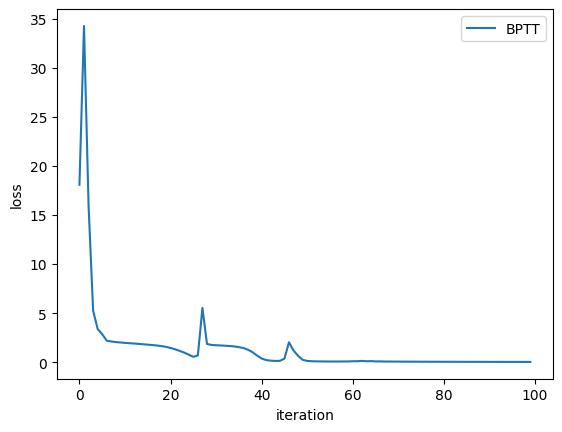

In [30]:
import matplotlib.pyplot as plt

plt.plot(llst1,  label='BPTT')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()

In [35]:
llst2 = []
llst2 = bptt_online()


llst3 = []
llst3 = bptt_online(fptt=True)

iter  0: y_pred = [ 0.04135, -0.05685, -0.03941,  0.08085,  0.11431,  0.13578,  0.26218,  0.46808,  0.51902,  0.41715], loss: 5.458e+00
iter  1: y_pred = [-0.01055, -0.02029,  0.01962,  0.07826,  0.10052,  0.09445,  0.15062,  0.29023,  0.30265,  0.21128], loss: 2.701e+00
iter  2: y_pred = [ 0.01906,  0.03883,  0.09010,  0.13870,  0.15278,  0.13138,  0.17651,  0.31595,  0.29632,  0.17241], loss: 2.221e+00
iter  3: y_pred = [ 0.00956,  0.03858,  0.09491,  0.14350,  0.16470,  0.14701,  0.19146,  0.34585,  0.29842,  0.14327], loss: 1.953e+00
iter  4: y_pred = [-0.00876,  0.02725,  0.08982,  0.14210,  0.17383,  0.16602,  0.21154,  0.38797,  0.30806,  0.11508], loss: 1.729e+00
iter  5: y_pred = [-0.03743,  0.00822,  0.08100,  0.13999,  0.18630,  0.19416,  0.23819,  0.43989,  0.31927,  0.07996], loss: 1.525e+00
iter  6: y_pred = [-0.07798, -0.01346,  0.07639,  0.14283,  0.20671,  0.23581,  0.26810,  0.49442,  0.32414,  0.03086], loss: 1.315e+00
iter  7: y_pred = [-0.13091, -0.02899,  0.08532,

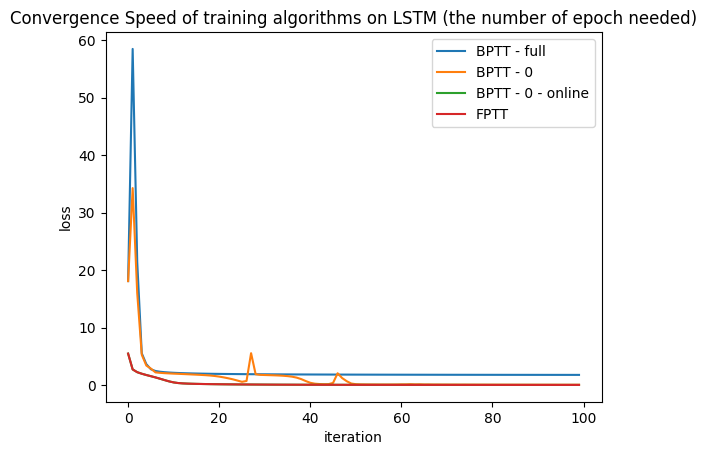

In [46]:
import matplotlib.pyplot as plt

plt.plot(llst,  label='BPTT - full')
plt.plot(llst1,  label='BPTT - 0')
plt.plot(llst2,  label='BPTT - 0 - online')
plt.plot(llst3,  label='FPTT')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.title("Convergence Speed of training algorithms on LSTM (the number of epoch needed)")
plt.show()